# ****Importing Libraries****

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras

**Librosa** is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems. By using Librosa, we can extract certain key features from the audio samples such as Tempo, Chroma Energy Normalized, Mel-Freqency Cepstral Coefficients, Spectral Centroid, Spectral Contrast, Spectral Rolloff, and Zero Crossing Rate.

**IPython.display.Audio** we can play audio in the notebook. It is a library used for playing the audio in the jupyterlab.

# **Reading the data from the dataset by setting the path**

In [ ]:
df=pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df.head()

# **Data preprocessing**

In [ ]:
df.shape

In [ ]:
df.dtypes

# **Dropping the unwanted labels**

In [ ]:
df=df.drop(labels='filename',axis=1)

# **Understanding the Audio Files**

In [ ]:
audio_recording="/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/country/country.00050.wav"
data , sr=librosa.load(audio_recording)
print(type(data),type(sr))

In [ ]:
librosa.load(audio_recording, sr=45600)

data, sr = librosa.load(audio_recording)
It loads and decodes the audio as a time series y.
sr = sampling rate of y. It is the number of samples per second. 20 kHz is the audible range for human beings. So it is used as the default value for sr. In this code we are using sr as 45600Hz.


# **Spectrogram visualization**




A spectrogram is a visual way of representing the signal loudness of a signal over time at various frequencies present in a particular waveform

In [ ]:
stft =librosa.stft(data)
stft_db =librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

In [ ]:
stft=librosa.stft(data)
stft_db=librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

**Spectral Rolloff** is the frequency below which a specified percentage of the total spectral energy, e.g. 85%

librosa.feature.spectral_rolloff computes the rolloff frequency for each frame in a signal.

In [ ]:
from sklearn.preprocessing import normalize
spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01,sr=sr)[0]
plt.figure(figsize=(12,4))
librosa.display.waveshow(data,sr=sr,alpha=0.4, color="#2B4F72")

**Chroma Feature**


It is a powerful tool for analyzing music features whose pitches can be meaningfully categorized and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music while being robust to changes in timbre and instrumentation.

In [ ]:
import librosa.display as lplt
chroma=librosa.feature.chroma_stft(data,sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma,sr=sr,x_axis='time',y_axis='chroma',cmap='coolwarm')
plt.colorbar()
plt.title("chroma Features")
plt.show()

**Zero crossing** is said to occur if successive samples have different algebraic signs. The rate at which zero-crossings occur is a simple measure of the frequency content of a signal. Zero-crossing rate is a measure of the number of times in a given time interval/frame that the amplitude of the speech signals passes through a value of zero.



In [ ]:
start=1000
end=1200
plt.figure(figsize=(14,5))
plt.plot(data[start:end],color="#2B4F72")
plt.grid()

In [ ]:
zero_cross_rate=librosa.zero_crossings(data[start:end],pad=False)
print("The number of zero-crossings is:",sum(zero_cross_rate))

# **Feature Extraction**

On the last column  is ‘label’ and will encode it with the function LabelEncoder() of sklearn.preprocessing. 

In [ ]:
class_list=df.iloc[:,-1]
convertor = LabelEncoder()

**fit_transform():** Fit label encoder and return encoded labels.

In [ ]:
y=convertor.fit_transform(class_list)

In [ ]:
y

In [ ]:
print(df.iloc[:,:-1])

# **Scaling the Features**

Standard scaler is used to standardize features by removing the mean and scaling to unit variance.

The standard score of sample x is calculated as:

z = (x - u) / s

In [ ]:
from sklearn.preprocessing import StandardScaler
fit=StandardScaler()
X=fit.fit_transform(np.array(df.iloc[:,:-1],dtype=float))

# **Dividing Data Into Training and Testing Sets**

In [ ]:
X_train ,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)


In [ ]:
len(y_train)

In [ ]:
len(y_test)

# **Building the Model**

Now comes the last part of the music classification genre project. The features have been extracted from the raw data and now we have to train the model. There are many ways through which we can train our model. Some of these approaches are:

* Multiclass Support Vector Machines
* K-Means Clustering
* K-Nearest Neighbors
* Convolutional Neural Networks

we will be using CNN Algorithm for training our model. We chose this approach because various forms of research show it to have the best results for this problem.

The following chart gives a clear view of why CNN algorithm is used:


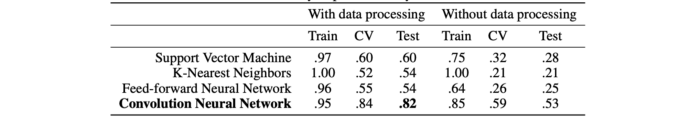

In [ ]:
from keras.models import Sequential

In [ ]:
def trainModel(model,epochs,optimizer):
    batch_size =128
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics='accuracy'
    )
    return model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

In [ ]:
def plotValidate(history):
    print("Validation Accuracy",max(history.history["val_accuracy"]))
    pd.Dataframe(history.history).plot(figsize=(12,6))
    plt.show()

In [ ]:
import keras as k

In [ ]:
model=k.models.Sequential([
    k.layers.Dense(512,activation='relu',input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    k.layers.Dense(256,activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(128,activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(64,activation='relu'),
    k.layers.Dropout(0.2),
    k.layers.Dense(10,activation='softmax'),   
])
print(model.summary())
model_history=trainModel(model=model,epochs=600,optimizer='adam')

For the CNN model, we had used the Adam optimizer for training the model. The epoch that was chosen for the training model is 600.

All of the hidden layers are using the RELU activation function and the output layer uses the softmax function. The loss is calculated using the sparse_categorical_crossentropy function.

Dropout is used to prevent overfitting.

We chose the Adam optimizer because it gave us the best results after evaluating other optimizers.

The model accuracy can be increased by further increasing the epochs but after a certain period, we may achieve a threshold, so the value should be determined accordingly.

# **Model Evaluation**

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test,batch_size=128)
print("The test Loss is:",test_loss)
print("\nThe Best test Accuracy is:",test_acc*100)